In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import torch

from sklearn.neighbors import KDTree
from sklearn.metrics import r2_score
from scipy.interpolate import griddata
from pathlib import Path

from datautilities import MeshIO as io
from datautilities import meshmethods as mm


In [2]:
torch.from_numpy(np.load("data/training-data/lr-nan-mask-region1.npy"))

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True,  True, False,
         True, False, False,  True,  True, False])

In [33]:
# years = [1964]
years = [1959, 1960, 1961, 1962, 1963]
lr_res = "LR8_raw_6cpu"
hr_res = "HR_6cpu"

nregion = 3
region = f"Region{nregion}LR4"

root_dir = Path("../../Data/")

lr_mesh = io.load_mesh(root_dir / region / "LR8_mesh.pickle")
hr_mesh = io.load_mesh(root_dir / region / "HR_mesh.pickle")

drop_idx_lr = np.load(root_dir / region / lr_res / "drop_index.npy")
drop_idx_hr = np.load(root_dir / region / hr_res / "drop_index.npy")

lr_coords = np.delete(lr_mesh.coords, drop_idx_lr, axis=0)
hr_coords = np.delete(hr_mesh.coords, drop_idx_hr, axis=0)


In [34]:
data = mm.load_data(res=lr_res, years=years, root_dir=root_dir / region, var="Dir")
# np.save(f"data/test-data/dir/lr-data-region{nregion}.npy", data)

In [35]:
nan_mask = ~np.isnan(data).all(axis=(0, 2))
# np.save(f"data/training-data/hr-nan-mask-region{nregion}.npy", nan_mask)
data = data[:, nan_mask]

In [36]:
np.save(f"data/training-data/dir/lr-znorm-region{nregion}.npy", np.vstack((data.mean(axis=(0, 1)), data.std(axis=(0, 1)))))

In [11]:
lr_raw = mm.load_data(years=years, res=lr_res, root_dir=(root_dir / region))
hr = mm.load_data(years=years, res=hr_res, root_dir=(root_dir / region))

lr_raw = np.delete(lr_raw, drop_idx_lr, axis=1)
hr = np.delete(hr, drop_idx_hr, axis=1)

/home/jannik/Documents/PhD/Super_Resolution_General/SROnUnstructuredGrids/datautilities/datautilities/meshmethods.py:106: RuntimeWarning: invalid value encountered in cast
  data[idx] = np.load(fpath).squeeze()


In [72]:
def knn_upsampling(lr_coords, lr_data, hr_coords, k=3):
    tree = KDTree(lr_coords)
    dist, idx = tree.query(hr_coords, k=k)
    weights = 1 / dist**2
    weights /= np.sum(weights, axis=1)[:, np.newaxis] 
    return np.sum(weights * lr_data[:, idx], axis=-1)


def refill_nan(data, drop_idx, axis=-1):
    range_idx = np.arange(len(drop_idx))
    return np.insert(data, drop_idx - range_idx, np.nan, axis=axis)

In [73]:
# Initial upsampling of the data with griddata
first_hr = np.empty_like(hr)
for i in range(hr.shape[0]):
    first_hr[i] = griddata(lr_coords, lr_raw[i], hr_coords, method="cubic")

In [74]:
# Refill the nan values with k nearest neighbors
nan_idx = np.isnan(first_hr).any(axis=0)

nan_coords = hr_coords[nan_idx]
base_data = first_hr[:, ~nan_idx]

nan_data = knn_upsampling(hr_coords[~nan_idx], base_data, nan_coords, k=3)

up_hr = first_hr.copy()
up_hr[:, nan_idx] = nan_data
# up_hr = refill_nan(up_hr, drop_idx_hr)

In [75]:
# Compute mae, rmse, and max error between data and hr results
mae = np.nanmean(np.abs(up_hr - hr))
rmse = np.sqrt(np.nanmean((up_hr - hr)**2))
max_err = np.nanmax(np.abs(up_hr - hr))

print(f"MAE: {mae*100:.2f} cm")
print(f"RMSE: {rmse*100:.2f} cm")
print(f"Max Error: {max_err*100:.2f} cm")
print("Median Error: ", np.nanmedian(np.abs(up_hr - hr))*100)
print("Median Error: ", np.nanpercentile(np.abs(up_hr - hr)*100, 95))

MAE: 7.43 cm
RMSE: 16.41 cm
Max Error: 149.81 cm
Median Error:  1.7195848404975678
Median Error:  40.49097233672613


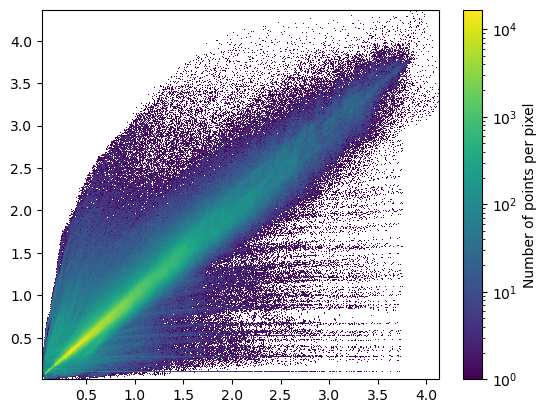

In [58]:
fig, ax = plt.subplots()

mm.scatter_density(up_hr.flatten(), hr.flatten(), ax=ax, norm="log")

In [45]:
r2 = r2_score(up_hr.flatten(), hr.flatten())

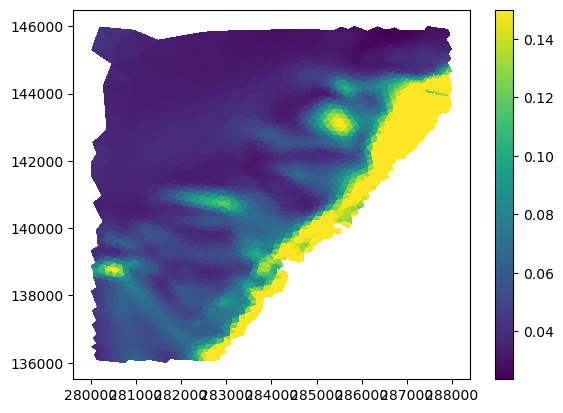

In [61]:
mean_diff = np.nanmean(np.abs(up_hr - hr), axis=0)

# Refill the deleted nan values
mean_hr = refill_nan(mean_diff, drop_idx_hr, axis=0)

fig, ax = plt.subplots()
im = mm.plot_meshed_data(mean_hr, hr_mesh, ax=ax, cmap="viridis", vmax=0.15)
plt.colorbar(im)

plt.show()

In [46]:
print(r2)

0.959598880279232


In [130]:
# Compute mae, rmse, and max error between data and hr results at offshore node
nnode = 1057

mae = np.nanmean(np.abs(up_hr - nan_hr)[:, nnode])
rmse = np.sqrt(np.nanmean((up_hr - nan_hr)[:, nnode]**2))
max_err = np.nanmax(np.abs(up_hr - nan_hr)[:, nnode])

print(f"MAE: {mae*100:.2f} cm")
print(f"RMSE: {rmse*100:.2f} cm")
print(f"Max Error: {max_err*100:.2f} cm")

MAE: 20.61 cm
RMSE: 41.49 cm
Max Error: 253.10 cm


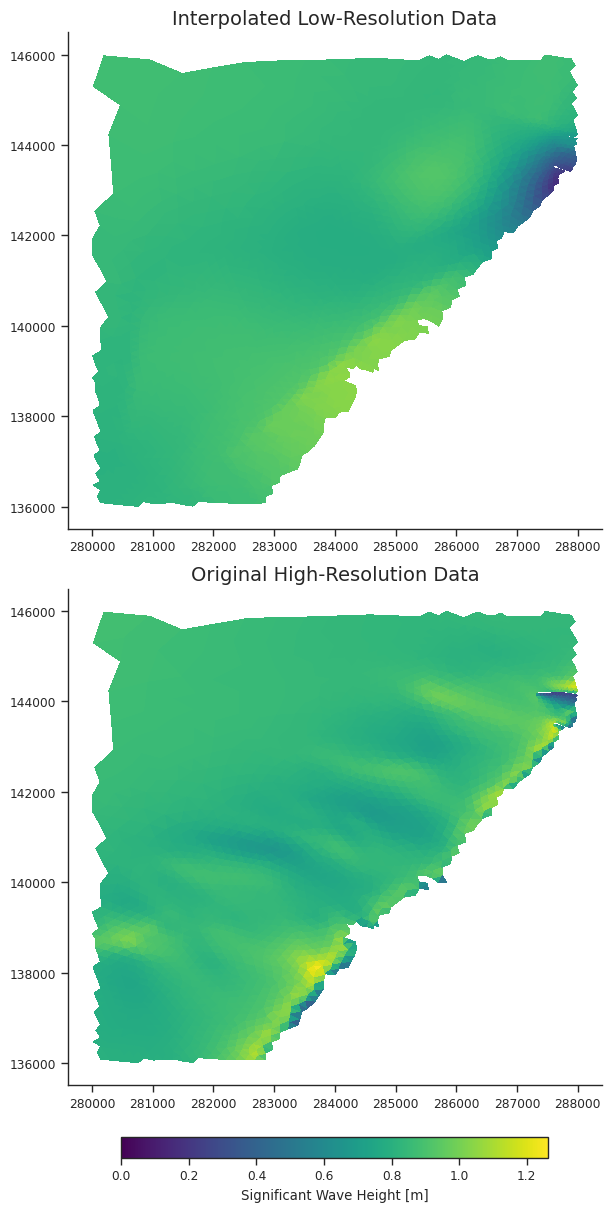

In [67]:
fig, axs = plt.subplots(2, 1, figsize=(6, 12), constrained_layout=True)
sns.set_theme(context="paper", style="ticks")
sns.despine()

plt.rcParams["axes.titlesize"] = 14

nsample = 491
data = up_hr[nsample]
hr_sample = nan_hr[nsample]

vmin = np.nanmin(np.r_[data, hr_sample])
vmax = np.nanmax(np.r_[data, hr_sample])

mm.plot_meshed_data(data, hr_mesh, ax=axs[0], vmin=vmin, vmax=vmax, cmap="viridis")
im = mm.plot_meshed_data(hr_sample, hr_mesh, ax=axs[1], vmin=vmin, vmax=vmax, cmap="viridis")

axs[0].set_title("Interpolated Low-Resolution Data")
axs[1].set_title("Original High-Resolution Data")

fig.colorbar(im, ax=axs[1], orientation="horizontal",
             label="Significant Wave Height [m]", shrink=0.8)

out_path = Path("plots") / f"region{nregion}" / f"griddata-upsampling-{nsample}.png"
out_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(out_path, bbox_inches="tight")